<a href="https://colab.research.google.com/github/olivieradjagba/vehicule-reidentification/blob/main/vehicule_reidentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, we are going to experient Vehicule re-identification

# Project setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

path = '/content/gdrive/MyDrive/Computer Vision/'
# path = '/content/gdrive/MyDrive/AIMS'
!pwd
# %cd '/content/gdrive/MyDrive/Computer Vision/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


In [ ]:
import numpy as np
import pandas as pd
from itertools import chain
import os
from pathlib import Path

# set a seed to ensure reproducibility
seed = 123
np.random.seed(seed)
rnd  = np.random.RandomState(seed)

# Matplotlib plotting settings
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
# print('matplotlib version: {}'.format(mp.__version__))
import seaborn as sns

FONTSIZE = 11
params = {
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE}
plt.rcParams.update(params)

In [ ]:
from PIL import Image
import requests
import xml.etree.ElementTree as ET

import tensorflow as tf
import keras
from keras import models, layers, optimizers, metrics, callbacks#Sequential, Model, load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Setup

## Data pre-processing

In [ ]:
from collections import defaultdict

class PreProcessing:

  def __init__(self, data_dir, target_shape=(224,224)):
    self.data_dir = data_dir
    self.target_shape = target_shape

  def normalize(self,x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    return x

  def get_labels(self, subdir, xml_file:str) -> dict[str,str]|None:
    xml_file_path = os.path.join(self.data_dir, xml_file)
    container = os.path.join(self.data_dir, subdir)
    labels = defaultdict(list)

    try:
      with open(xml_file_path, 'r') as file:
        xml_content = file.read()
        root = ET.fromstring(xml_content)
      for attrs in root.iter('Item'):
        id = attrs.attrib['vehicleID']
        path = os.path.join(container, attrs.attrib['imageName'])
        labels[id].append(path)
        # if id in labels:
        #   labels[id].append(attrs.attrib['imageName'])
        # else:
        #   labels[id] = [attrs.attrib['imageName']]
        # labels[id][-1] = os.path.join(container, labels[id][-1])

      return labels

    except FileExistsError:
      print(f"The XML file '{xml_file}' doesus-ascii not exist in {self.data_dir} directory.")


  def preprocess_image(self, filename:str):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, self.target_shape)
    return image


  def preprocess_triplet(self, anchor:str, positive:str, negative:str):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
      self.preprocess_image(anchor),
      self.preprocess_image(positive),
      self.preprocess_image(negative),
    )

  def preprocessing(self, subdir:str, xml_file:str='', n:int=0, batch_size:int=32, val_ratio:float|None=None):
    if xml_file:
      labels = self.get_labels(subdir, xml_file)
      unique_labels = list(labels.keys())
      triplets = [self.get_triplet(labels, unique_labels) for _ in range(n)]
      data = tf.data.Dataset.from_tensor_slices(triplets).map(lambda x: self.preprocess_triplet(x[0], x[1], x[2]))

      if val_ratio:
        val_data   = data.take(round(n * val_ratio))
        val_data   = val_data.batch(32, drop_remainder=False)
        val_data   = val_data.prefetch(8)
        train_data = data.skip(round(n * val_ratio))
        train_data = train_data.batch(32, drop_remainder=False)
        train_data = train_data.prefetch(8)
        return train_data, val_data

      data = data.batch(32, drop_remainder=False)
      data = data.prefetch(8)
      return data

    lab_list = [p for p in os.listdir(os.path.join(self.data_dir, subdir))]
    data = tf.data.Dataset.from_tensor_slices(lab_list).map(self.preprocess_image)
    return data


  def get_triplet(self, labels:dict[str,str], unique_labels:list[str]) -> tuple[str,str,str]:
    ap_id, n_id = np.random.choice(unique_labels, 2, replace=False)
    a, p = np.random.choice(labels[ap_id],2, replace=False)
    n = np.random.choice(labels[n_id])
    return a, p, n

  def visualize(self, anchor, positive, negative, nsbp=(3,3), figsize=(9,9),):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
      ax.imshow(image)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=figsize)

    axs = fig.subplots(*nsbp)
    for i in range(3):
      show(axs[i, 0], anchor[i])
      show(axs[i, 1], positive[i])
      show(axs[i, 2], negative[i])



## Eucleudian distance layer

In [ ]:
class DistanceLayer(layers.Layer):
  """
  This layer is responsible for computing the distance between the anchor
  embedding and the positive embedding, and the anchor embedding and the
  negative embedding.
  """

  # @tf.keras.utils.register_keras_serializable()
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def get_config(self):
    config = super(DistanceLayer, self).get_config()
    return config

  def call(self, anchor, positive, negative):
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_distance, an_distance)

In [ ]:
class SiameseModel(models.Model):
  """The Siamese Network model with a custom training and testing loops.

  Computes the triplet loss using the three embeddings produced by the
  Siamese Network.

  The triplet loss is defined as:
      L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
  """

  def __init__(self, siamese_network, margin=0.5):
    super().__init__()
    self.siamese_network = siamese_network
    self.margin = margin
    self.loss_tracker = metrics.Mean(name="loss")

  def call(self, inputs):
    return self.siamese_network(inputs)

  def train_step(self, data):
    # GradientTape is a context manager that records every operation that
    # you do inside. We are using it here to compute the loss so we can get
    # the gradients and apply them using the optimizer specified in
    # `compile()`.
    with tf.GradientTape() as tape:
      loss = self._compute_loss(data)

    # Storing the gradients of the loss function with respect to the
    # weights/parameters.
    gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

    # Applying the gradients on the model using the specified optimizer
    self.optimizer.apply_gradients(
      zip(gradients, self.siamese_network.trainable_weights)
    )

    # Let's update and return the training loss metric.
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  def test_step(self, data):
    loss = self._compute_loss(data)

    # Let's update and return the loss metric.
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  def _compute_loss(self, data):
    # The output of the network is a tuple containing the distances
    # between the anchor and the positive example, and the anchor and
    # the negative example.
    ap_distance, an_distance = self.siamese_network(data)

    # Computing the Triplet Loss by subtracting both distances and
    # making sure we don't get a negative value.
    loss = ap_distance - an_distance
    loss = tf.maximum(loss + self.margin, 0.0)
    return loss

  @property
  def metrics(self):
    # We need to list our metrics here so the `reset_states()` can be
    # called automatically.
    return [self.loss_tracker]

## Embedding

In [ ]:
class Embedding:
  def __init__(self, base_cnn:models.Model|None=None, path:str|None=None) -> None:
    if base_cnn:
      flatten = layers.Flatten()(base_cnn.output)
      dense1 = layers.Dense(512, activation="relu")(flatten)
      dense1 = layers.BatchNormalization()(dense1)
      dense2 = layers.Dense(256, activation="relu")(dense1)
      dense2 = layers.BatchNormalization()(dense2)
      output = layers.Dense(256)(dense2)

      self.embedding = models.Model(base_cnn.input, output, name="Embedding")
    else:
      self.embedding = self.load(path)

  def get_embedding(self,img):
    return self.embedding.predict(img)

  def get_embeddings(self, imgs):
    return tf.data.Dataset.from_tensor_slices(imgs).map(self.get_embedding)

  def perwise_distance(self, query, test):
    return tf.reduce_sum(tf.square(test - query), -1)

  def euclidian_distance(self, queries, tests):
    d = queries.map(lambda q: tests.map(lambda t: self.perwise_distance(q, t)))
    return d

  def save(self, path):
    tf.keras.models.save_model(self.embedding, path)
    self.embedding.save(path)

  def load(self, path):
    # self.embedding = models.load_model(path)
    # return models.load_model(path)
    return tf.keras.models.load_model(path, custom_objects={'DistanceLayer': DistanceLayer})

# Data setup

## Initialisation

In [ ]:
INPUT_SHAPE = (224,224,3)
EPOCHS = 10
DATA_SIZE = 20000
MODEL_PATH = os.path.join(path,'model.keras')
checkpoint_fun = lambda filepath: callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

## Data downloading
The dataset used is CIFAR-10 from keras. It contains 50000 training data samples and 10000 test data samples.

In [ ]:
## Data dir
data_dir = 'data/'
try:
  # os.makedirs(data_dir)
  !gdown 1sJ31Lq1uKMq9f1P0sDGtHUP5Yl8X7YKE
  !unzip -q 'VeRi.zip'
  # !unzip -q '/content/gdrive/MyDrive/Computer Vision/VeRi.zip'
  !mv VeRi/* data
  # !rm VeRi.zip
  !rm -rf VeRi
except FileExistsError:
  print("The file already exists")

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
mv: cannot stat 'VeRi/*': No such file or directory


## Data loading

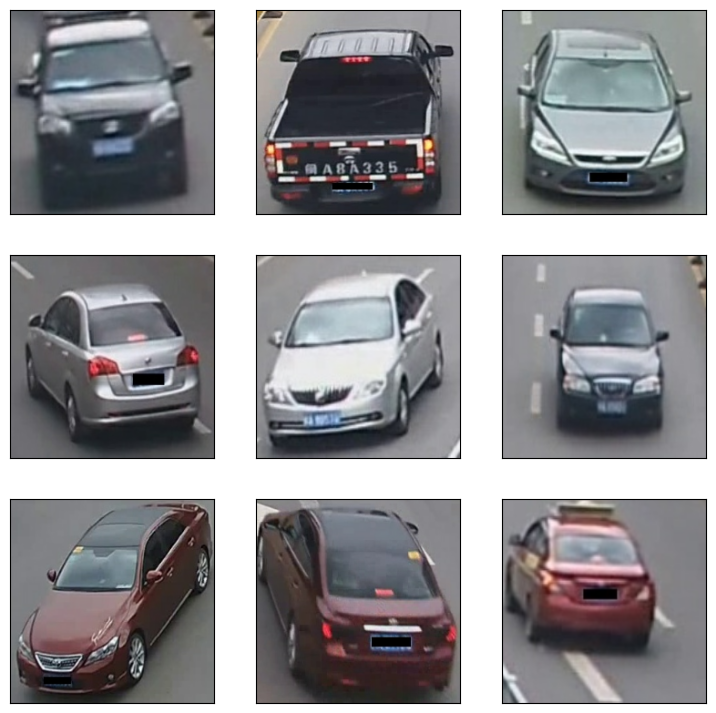

In [ ]:
data_setup = PreProcessing('data')
train, val = data_setup.preprocessing('image_train', 'train_label.xml', n=DATA_SIZE,  val_ratio=0.15)
test = data_setup.preprocessing('image_test')
query = data_setup.preprocessing('image_query')

data_setup.visualize(*list(train.take(1).as_numpy_iterator())[0])


# Model

## Resnet50 model fine-turning

In [ ]:
base_cnn = ResNet50(
    weights="imagenet", input_shape=INPUT_SHAPE, include_top=False
)
# embedding = models.Model(base_cnn.input, output, name="Embedding")
embedding = Embedding(base_cnn)

anchor_input = layers.Input(name="anchor", shape=INPUT_SHAPE)
positive_input = layers.Input(name="positive", shape=INPUT_SHAPE)
negative_input = layers.Input(name="negative", shape=INPUT_SHAPE)

distances = DistanceLayer()(
  embedding.embedding(preprocess_input(anchor_input)),
  embedding.embedding(preprocess_input(positive_input)),
  embedding.embedding(preprocess_input(negative_input)),
)

triple_network = models.Model(
  inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

## Training

In [ ]:
triple_ntk_model = SiameseModel(triple_network)
triple_ntk_model.compile(optimizer=optimizers.Adam(0.0001), metrics=['loss'], weighted_metrics=[])
# triple_ntk_model.summary()
history = triple_ntk_model.fit(train, validation_data=val, epochs=EPOCHS, callbacks=[checkpoint_fun])

Epoch 1/5
532/532 [==============================] - 598s 1s/step - loss: 0.3058 - val_loss: 0.2698
Epoch 2/5
532/532 [==============================] - 555s 1s/step - loss: 0.3108 - val_loss: 0.3217
Epoch 3/5
532/532 [==============================] - 554s 1s/step - loss: 0.3025 - val_loss: 0.2607
Epoch 4/5
532/532 [==============================] - 573s 1s/step - loss: 0.2749 - val_loss: 0.2668
Epoch 5/5
532/532 [==============================] - 559s 1s/step - loss: 0.2760 - val_loss: 0.2548


## Metrics visualisation

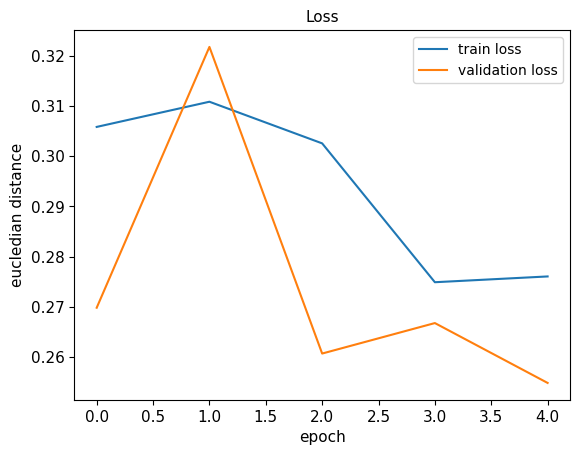

In [ ]:
# triple_ntk_model.save("model.keras")
history.history
plt.plot(history.epoch, history.history['loss'], label='train loss')
plt.plot(history.epoch, history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('eucledian distance')
plt.legend()
plt.show()

## Features embedding

In [ ]:
def get_embedding(img):
  return embedding.embedding.predict(img)

def get_embeddings(imgs):
  return imgs.map(get_embedding)

def perwise_distance(query, test):
  return np.sum(np.square(test - query), axis=1)

def euclidian_distance(queries, tests):
  d = [perwise_distance(q, t) for q in queries for t in tests]
  return d

In [ ]:
test_labels = [os.path.join(data_dir, 'image_test', l) for l in os.listdir(os.path.join(data_dir,'image_test'))]
query_labels = [os.path.join(data_dir, 'image_query', l) for l in os.listdir(os.path.join(data_dir,'image_query'))]

t = 1000;   q = 3;    m = 5
test_labels = np.random.choice(test_labels, t, replace=False)
query_labels = np.random.choice(query_labels, q, replace=False)

In [ ]:
query_imgs = []
for qq in query_labels:
  img = data_setup.preprocess_image(qq)
  query_imgs.append(img)

test_imgs = []
for tt in test_labels:
  img = data_setup.preprocess_image(tt)
  test_imgs.append(img)

In [ ]:
query_embed = []
for qq in query_imgs:
  emb = embedding.embedding(np.expand_dims(qq, 0))
  query_embed.append(emb)

test_embed = []
for tt in test_imgs:
  emb = embedding.embedding(np.expand_dims(tt, 0))
  test_embed.append(emb)

In [ ]:
eucl_dist = euclidian_distance(query_embed, test_embed)
eucl_dist = np.array([d[0] for d in eucl_dist])
dist_idx = np.argsort(eucl_dist)

In [ ]:
top_query = []
top_lab = []
q_lab = []
get_id = lambda l: l.split('/')[-1].split('_')[0]
for i,qq in enumerate(query_labels):
  qid = get_id(qq)
  dist_idx = np.argsort(eucl_dist[t*i : t*(i+1)])[:m]
  img = [test_imgs[idx] for idx in dist_idx]
  lab = [get_id(test_labels[idx]) for idx in dist_idx]
  top_query.append(img)
  top_lab.append(lab)
  q_lab.append(qid)


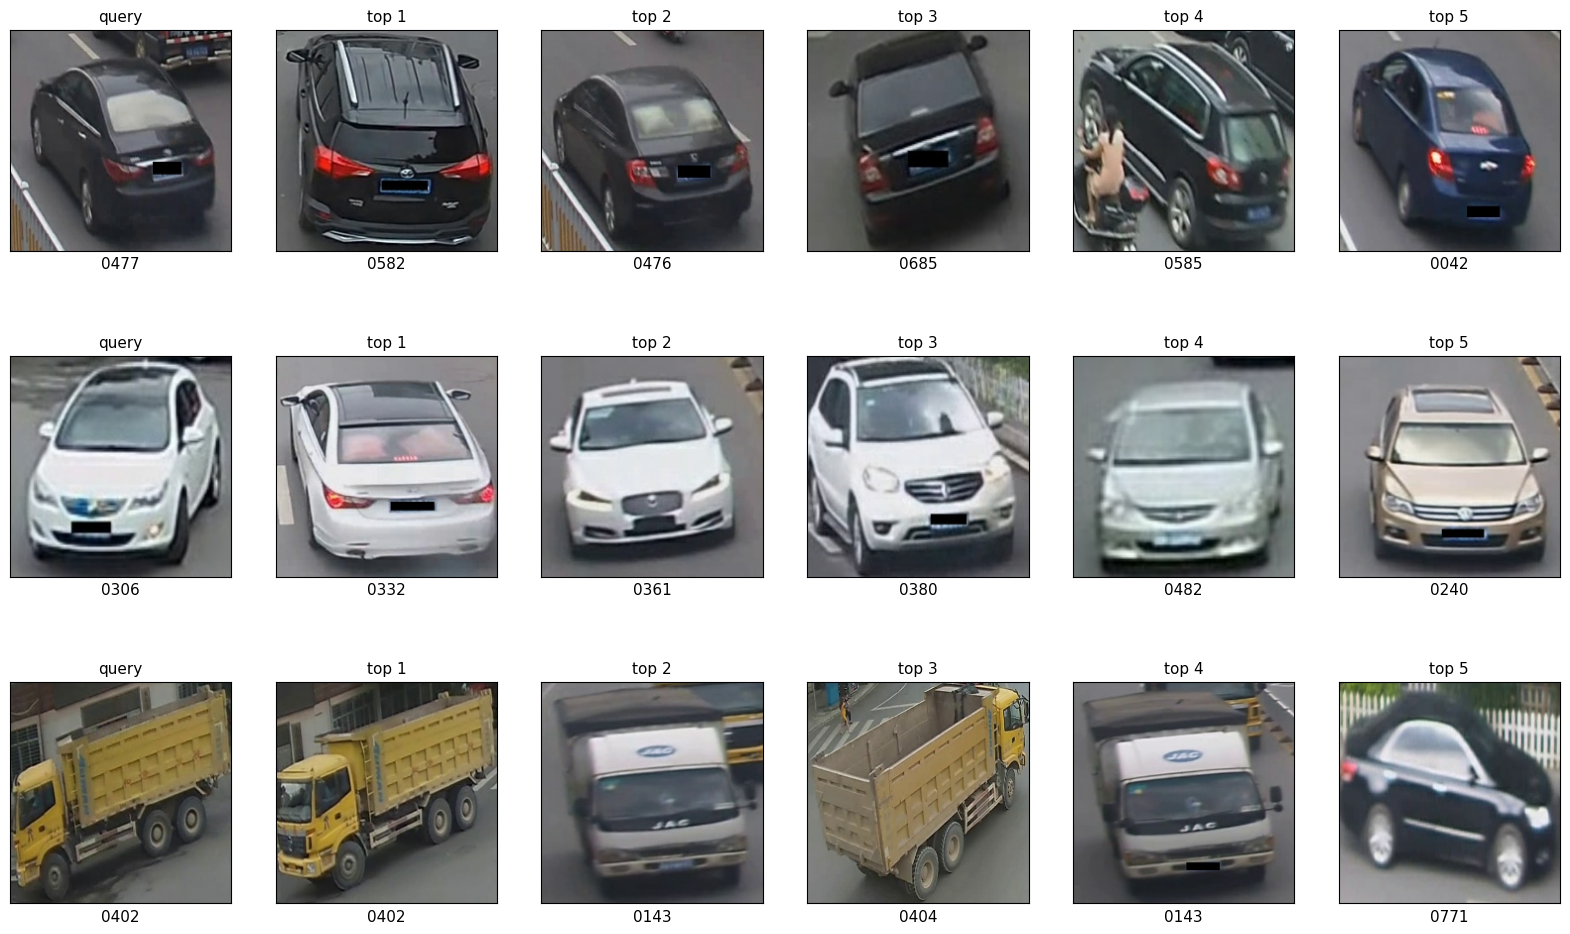

In [ ]:
fig, axes = plt.subplots(q, m+1, figsize=(20, 12))
for i in range(q):
  axes[i,0].imshow(query_imgs[i])
  axes[i,0].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
  axes[i,0].set_title('query')
  axes[i,0].set_xlabel(f'{q_lab[i]}')
  for j in range(m):
    axes[i,j+1].imshow(top_query[i][j])
    axes[i,j+1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    axes[i,j+1].set_title(f'top {j+1}')
    axes[i,j+1].set_xlabel(f'{top_lab[i][j]}')

plt.show()

## Accuracy

In [ ]:
top1_acc = 0
top5_acc = 0
tp = fp = fn = 0
for i, qq in enumerate(q_lab):
  if qq in top_lab[i]:
    if top_lab[i][0] == qq:
      print(qq, top_lab[i][0])
      top1_acc += 1
    top5_acc += 1
top1_acc /= q*m
top5_acc /= q*m
print('Top 1 accuracy:', top1_acc)
print('Top 5 accuracy:', top5_acc)

0402 0402
Top 1 accuracy: 0.06666666666666667
Top 5 accuracy: 0.06666666666666667
